# Install Transformers Library

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 4.1 MB/s 
     |████████████████████████████████| 182 kB 78.4 MB/s 
     |████████████████████████████████| 7.6 MB 77.5 MB/s 


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

# specify GPU
device = torch.device("cuda")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load Dataset

In [ ]:
ham_emails = pd.read_csv("/content/drive/My Drive/thesis/ham_emails.csv")

In [ ]:
phishing_emails = pd.read_csv("/content/drive/My Drive/thesis/phishing_emails.csv")

In [ ]:
df = pd.concat([ham_emails[:3054], phishing_emails])

In [ ]:
# df = pd.read_csv("/content/drive/My Drive/thesis/all_emails.csv")
df.rename(columns = {'is_phishing':'label'}, inplace = True)
df.rename(columns = {'message':'text'}, inplace = True)
df.head()

,text,label
0,Scott: The response from Richard is that we a...,0
1,Demand charges are showing up now. We still h...,0
2,Please print this monster. Kay,0
3,Give the gift of The Wall Street Journal at...,0
4,"So, I got the scoop from Phil, and he says tha...",0


In [ ]:
df.sample(frac=1).head()

,text,label
1525,----- Forwarded by Sara Shackleton/HOU/ECT on ...,0
780,Tom: I just received a phone call from Bear S...,0
755,"Hello Everyone, I made it to Singapore at 1:0...",0
41,Email Storage Alert for - Account User: We not...,1
1305,Important Craigslist Information CRAIGSLIST TE...,1


In [ ]:
# check class distribution
df['label'].value_counts(normalize = True)

0    0.5
1    0.5
Name: label, dtype: float64

# Split train dataset into train, validation and test sets

In [ ]:
train_text, temp_text, train_labels, temp_labels = train_test_split(df['text'], df['label'], 
                                                                    random_state=2018, 
                                                                    test_size=0.3, 
                                                                    stratify=df['label'])

# we will use temp_text and temp_labels to create validation and test set
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2018, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

In [ ]:
masked_phishing = pd.read_csv("/content/drive/My Drive/thesis/masked_phishing_df.csv")
masked_ham = pd.read_csv("/content/drive/My Drive/thesis/masked_ham_df.csv")
masked_phishing['label'] = 1
masked_ham['label'] = 0
masked_all = pd.concat([masked_phishing, masked_ham])

In [ ]:
masked_ham.loc[len(masked_ham['message']) > 100]

KeyError: ignored

In [ ]:
training_df = pd.DataFrame(columns=['train_text', 'train_labels'])
training_df['train_text'] = train_text
training_df['train_labels'] = train_labels

In [ ]:
testing_df = pd.DataFrame(columns=['test_text', 'test_labels'])
testing_df['test_text'] = test_text
testing_df['test_labels'] = test_labels

In [ ]:
testing_masked = pd.DataFrame(columns=['test_text', 'test_labels'])
testing_masked['test_text'] = masked_all['message']
testing_masked['test_labels'] = masked_all['label']

In [ ]:
val_df = pd.DataFrame(columns=['val_text', 'val_labels'])
val_df['val_text'] = val_text
val_df['val_labels'] = val_labels

In [ ]:
trainin_dff = training_df.dropna()
tetin_df = testing_df.dropna()
vall_df = val_df.dropna()
testing_masked = testing_masked.dropna()

# Import BERT Model and BERT Tokenizer

In [ ]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
# sample data
text = ["this is a good day", "we will fine-tune a bert model"]

# encode text
sent_id = tokenizer.batch_encode_plus(text, padding=True, return_token_type_ids=False)

# output
print(sent_id)

{'input_ids': [[101, 2023, 2003, 1037, 2204, 2154, 102, 0, 0, 0], [101, 2057, 2097, 2986, 1011, 8694, 1037, 14324, 2944, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


# Tokenization

In [ ]:
# get length of all the messages in the train set
seq_len = []
for i in trainin_dff['train_text']:
  try:
    leni = len(i.split())
    seq_len.append(leni)
  except:
    pass



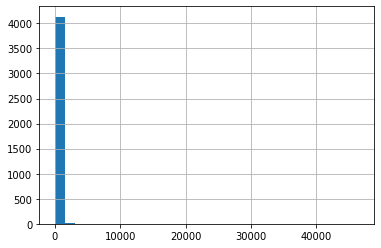

In [ ]:
pd.Series(seq_len).hist(bins = 30)

In [ ]:
max_seq_len = 25

In [ ]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    trainin_dff['train_text'].tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False,
)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2310: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    vall_df['val_text'].tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

In [ ]:


# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    tetin_df['test_text'].tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

In [ ]:
# tokenize and encode sequences in the test set
tokens_masked = tokenizer.batch_encode_plus(
    testing_masked['test_text'].tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2310: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


# Convert Integer Sequences to Tensors

In [ ]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(trainin_dff['train_labels'].tolist())

# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(vall_df['val_labels'].tolist())

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(tetin_df['test_labels'].tolist())

# for masked set
masked_seq = torch.tensor(tokens_masked['input_ids'])
masked_mask = torch.tensor(tokens_masked['attention_mask'])
masked_y = torch.tensor(testing_masked['test_labels'].tolist())

# Create DataLoaders

In [ ]:
test_seq.size()

torch.Size([900, 25])

In [ ]:
test_mask.size()

torch.Size([900, 25])

In [ ]:
test_y.size()

torch.Size([900])

In [ ]:
train_yy= train_y[:4768]

In [ ]:
train_seq

tensor([[  101,  2168,  1012,  ...,  2102,  1010,   102],
        [  101,  2115,  5653,  ...,  5787,  2029,   102],
        [  101, 25207,  3931,  ...,  2000,  1999,   102],
        ...,
        [  101,  2023,  4471,  ...,  2612,  1997,   102],
        [  101,  6203,  8836,  ...,  3252,  1010,   102],
        [  101,  2000,  5676,  ...,  2050,  1012,   102]])

In [ ]:
train_mask

tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]])

In [ ]:
train_y

tensor([0, 1, 1,  ..., 1, 0, 1])

In [ ]:
train_yy.size()

torch.Size([4160])

In [ ]:
val_seq.size()

torch.Size([891, 25])

In [ ]:
val_mask.size()

torch.Size([891, 25])

In [ ]:
val_y.size()

torch.Size([891])

In [ ]:
val_yy = val_y[:1033]

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

# Freeze BERT Parameters

In [ ]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

# Define Model Architecture

In [ ]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)
      
      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      
      # apply softmax activation
      x = self.softmax(x)

      return x

In [ ]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [ ]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


# Find Class Weights

In [ ]:
from sklearn.utils import compute_class_weight

#compute the class weights
class_wts = compute_class_weight(
                                  class_weight='balanced',
                                  classes=np.unique(train_labels),
                                  y = train_labels
                                 )

print(class_wts)

[1.00023397 0.99976614]


In [ ]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 10

# Fine-Tune BERT

In [ ]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [ ]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

# Start Model Training

In [ ]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), '/content/drive/MyDrive/thesis/emotions_model/checkpoints/detection_2111.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 10


KeyboardInterrupt: ignored

# Load Saved Model

In [ ]:
#load weights of best model
# path = 'saved_weights.pt'
path ='/content/drive/MyDrive/thesis/emotions_model/checkpoints/detection_2111.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

# Get Predictions for Test Data

In [ ]:
# get predictions for test data
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds_test = preds.detach().cpu().numpy()

In [ ]:
type(preds_test)

numpy.ndarray

In [ ]:
preds_test.shape

(900, 2)

In [ ]:
# model's performance
preds = np.argmax(preds_test, axis = 1)
print(classification_report(test_y, preds))


              precision    recall  f1-score   support

           0       0.96      0.92      0.94       442
           1       0.93      0.96      0.94       458

    accuracy                           0.94       900
   macro avg       0.94      0.94      0.94       900
weighted avg       0.94      0.94      0.94       900



In [ ]:

# get predictions for masked data
with torch.no_grad():
  preds = model(masked_seq.to(device), masked_mask.to(device))
  preds_masked = preds.detach().cpu().numpy()

In [ ]:
# model's performance
preds = np.argmax(preds_masked, axis = 1)
print(classification_report(masked_y, preds))

              precision    recall  f1-score   support

           0       0.91      0.91      0.91      2929
           1       0.90      0.91      0.91      2902

    accuracy                           0.91      5831
   macro avg       0.91      0.91      0.91      5831
weighted avg       0.91      0.91      0.91      5831



In [ ]:
preds.shape

(2,)

In [ ]:
# confusion matrix
pd.crosstab(test_y, preds)

col_0,0,1
row_0,,
0,412,30
1,14,444


In [ ]:
# making predictions to get FN for phishing
counter = 0 
false_negative = []
# false_positive = []
for message in phishing_emails['message'].tolist():
    
    try:

      tokens_test = tokenizer.batch_encode_plus(
          [message],
          max_length = max_seq_len,
          pad_to_max_length=True,
          truncation=True,
          return_token_type_ids=False
      )
    except Exception as e:
      print('exception', e)
      pass

    test_seq = torch.tensor(tokens_test['input_ids'])
    test_mask = torch.tensor(tokens_test['attention_mask'])
    test_y  = torch.tensor(tetin_df['test_labels'].tolist())

    # get predictions for test data
    with torch.no_grad():
      preds = model(test_seq.to(device), test_mask.to(device))
      preds = preds.detach().cpu().numpy()

    preds = np.argmax(preds, axis = 1)
    
    if preds[0] == 0:
      print(counter, message)
      false_negative.append(message)
    counter = counter + 1


    

In [ ]:
    # Make predictions by changing '[ham_emails['message'][1225]]
    
    tokens_test = tokenizer.batch_encode_plus(
        [ham_emails['message'][1225]],
        max_length = max_seq_len,
        pad_to_max_length=True,
        truncation=True,
        return_token_type_ids=False
    )

    test_seq = torch.tensor(tokens_test['input_ids'])
    test_mask = torch.tensor(tokens_test['attention_mask'])
    test_y = torch.tensor(tetin_df['test_labels'].tolist())

    # get predictions for test data
    with torch.no_grad():
      preds = model(test_seq.to(device), test_mask.to(device))
      preds = preds.detach().cpu().numpy()


    preds = np.argmax(preds, axis = 1)
    print(preds[0])

0


In [ ]:
df_false_negative = pd.DataFrame()
df_false_positive = pd.DataFrame()
df_false_negative['false_negative'] = false_negative
df_false_positive['false_positive'] = false_positive

In [ ]:
df_false_negative.to_csv('/content/drive/MyDrive/thesis/emotions_model/df_false_negative.csv')
df_false_positive.to_csv('/content/drive/MyDrive/thesis/emotions_model/df_false_positive.csv')

In [ ]:
# I tried something here before, it didn't work. Can't remember what exactly it was but not deleting

ham_ids_to_delete = [3968,3883,3810,3798,3763,3728,3692,3644,3471,3409,3323,3229,
                    3227,3209,3103,3016,2957,2939,2911,2892,2817,2792,2783,2769,
                    2751,2746,2680,2500,2437,2297,2278,2192,2155,2107,2044,1997,
                    1960,1910,1796,1682,1596,1569,1563,1520,1495,1492,1400,1393,
                    1380,1304,1297,1272,1191,1178,1156,1138,1126,1061,1046,989,
                    982,854,841,807,750,713,612,587,582,547,541,496,462,441,424,
                    385,356,335,301,292,269,265,252,174,144,86,50,43]
phishing_ids_to_delete = [2810, 2729, 2680, 2569, 2518, 2267, 2142, 2132, 2028,
                          1789, 1570, 1485, 1296, 1209, 1137,1123, 1070, 1043,
                          1029,944,762,745,732,524,488, 216,120,65]
phishing_emails_new = phishing_emails.replace('______________________________________________________________________','').replace('_______________________________________________','').replace('&#97;', 'a').replace('&#101;', 'e').replace('=2E','.').replace('- ', '').replace('&rsquo;','woul').replace('&#39;'," woul").replace('\t', ' ').replace('=20', '')
phishing_emails_new = phishing_emails_new.drop(phishing_emails_new.index[phishing_ids_to_delete])
ham_emails_new = ham_emails.drop(ham_emails.index[ham_ids_to_delete])
ham_emails_new = ham_emails_new.dropna()



In [ ]:
masked_phishing = pd.read_csv("/content/drive/My Drive/thesis/masked_phishing_df.csv")

In [ ]:
# Making predictions with data with their emotions masked

counter = 0 
true_pred = 0
false_pred = 0
for message in masked_phishing['message'].tolist():
    
    try:

      tokens_test = tokenizer.batch_encode_plus(
          [message],
          max_length = max_seq_len,
          pad_to_max_length=True,
          truncation=True,
          return_token_type_ids=False
      )
    except Exception as e:
      print('exception', e)
      pass

    test_seq = torch.tensor(tokens_test['input_ids'])
    test_mask = torch.tensor(tokens_test['attention_mask'])
    test_y  = torch.tensor(tetin_df['test_labels'].tolist())

    # get predictions for test data
    with torch.no_grad():
      preds = model(test_seq.to(device), test_mask.to(device))
      preds = preds.detach().cpu().numpy()

    preds = np.argmax(preds, axis = 1)
    
    if preds[0] == 0:
      false_pred = false_pred + 1

    if preds[0] == 1:
      true_pred = true_pred + 1


    

exception TextEncodeInput must be Union[TextInputSequence, Tuple[InputSequence, InputSequence]]
exception TextEncodeInput must be Union[TextInputSequence, Tuple[InputSequence, InputSequence]]
exception TextEncodeInput must be Union[TextInputSequence, Tuple[InputSequence, InputSequence]]
exception TextEncodeInput must be Union[TextInputSequence, Tuple[InputSequence, InputSequence]]
exception TextEncodeInput must be Union[TextInputSequence, Tuple[InputSequence, InputSequence]]
exception TextEncodeInput must be Union[TextInputSequence, Tuple[InputSequence, InputSequence]]
exception TextEncodeInput must be Union[TextInputSequence, Tuple[InputSequence, InputSequence]]
exception TextEncodeInput must be Union[TextInputSequence, Tuple[InputSequence, InputSequence]]
exception TextEncodeInput must be Union[TextInputSequence, Tuple[InputSequence, InputSequence]]
exception TextEncodeInput must be Union[TextInputSequence, Tuple[InputSequence, InputSequence]]
exception TextEncodeInput must be Union[